# Install VADER
[vaderSentiment](https://github.com/cjhutto/vaderSentiment)

`>pip install vaderSentiment`

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Trump approval rating
Trump approval rating data gathered from [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/trump-approval-ratings), under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

In [2]:
df = pd.read_csv('https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv')
#change `modeldate` data type to datetime.date
for index,row in df.iterrows():
    df.at[index,'modeldate'] = datetime.strptime(row['modeldate'], '%m/%d/%Y').date()
df.head(10)

,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,Voters,2018-04-11,41.80294,46.28046,37.32541,53.03569,56.98950,49.08189,11:31:51 11 Apr 2018
1,Donald Trump,Adults,2018-04-11,39.42455,43.05485,35.79425,53.94310,59.00719,48.87902,11:31:40 11 Apr 2018
2,Donald Trump,All polls,2018-04-11,40.66014,45.39441,35.92587,53.14995,57.59991,48.69998,11:31:29 11 Apr 2018
3,Donald Trump,Voters,2018-04-10,41.75703,46.24847,37.26559,53.15528,57.17596,49.13460,15:52:50 10 Apr 2018
4,Donald Trump,Adults,2018-04-10,39.34561,42.95245,35.73876,54.23932,58.78645,49.69218,15:52:40 10 Apr 2018
5,Donald Trump,All polls,2018-04-10,40.60616,45.30262,35.90969,53.35361,57.63873,49.06849,15:52:29 10 Apr 2018
6,Donald Trump,Adults,2018-04-09,39.34561,42.95245,35.73876,54.23932,58.78645,49.69218,18:18:04 9 Apr 2018
7,Donald Trump,Voters,2018-04-09,41.16166,45.75655,36.56676,54.16276,58.16358,50.16194,18:18:15 9 Apr 2018
8,Donald Trump,All polls,2018-04-09,40.23806,45.03144,35.44468,53.88530,58.19486,49.57573,18:17:53 9 Apr 2018
9,Donald Trump,Voters,2018-04-08,41.01259,45.40462,36.62057,54.23832,58.18184,50.29480,09:37:06 9 Apr 2018


We want the daily approval estimate from all polls.

In [3]:
approval_estimates = df[df['subgroup'] == 'All polls'][['modeldate','approve_estimate']]
approval_estimates.head()

,modeldate,approve_estimate
2,2018-04-11,40.66014
5,2018-04-10,40.60616
8,2018-04-09,40.23806
10,2018-04-08,39.96867
13,2018-04-07,39.96867


# Sentiment analysis of Trump's tweets
[Trump tweet analysis by NPR Apps](https://github.com/nprapps/trump-tweet-analysis/blob/master/trump-tweets.ipynb)

[What We Learned About The Mood Of Trump's Tweets](https://www.npr.org/2017/04/30/526106612)

The code below downloads a `.zip` of Trump tweets from an [archive](https://github.com/bpb27/trump_tweet_data_archive) updated every hour.

In [20]:
import requests
import zipfile
import io

response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/condensed_2018.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Load the JSON data into a DataFrame.

In [4]:
with open('data/condensed_2018.json') as f:
    jsondata = json.load(f)

tweets = pd.read_json('data/condensed_2018.json')
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2018-03-29 20:06:37,77534,979449770640015360,NaN,False,20072,Twitter for iPhone,Washington spent trillions building up foreign...
1,2018-03-29 19:58:35,54539,979447750529110016,NaN,False,13529,Twitter for iPhone,"JOBS, JOBS, JOBS! Unemployment claims have fal..."
2,2018-03-29 19:44:06,56138,979444104923840512,NaN,False,12922,Twitter for iPhone,We are going to REBUILD our crumbling infrastr...
3,2018-03-29 11:57:38,112077,979326715272065024,NaN,False,29771,Twitter for iPhone,I have stated my concerns with Amazon long bef...
4,2018-03-28 21:31:54,41557,979108846408003584,25073877.0,False,8840,Twitter for iPhone,"....In the interim, Hon. Robert Wilkie of DOD ..."


## Processing the data

For each tweet, run sentiment analysis on the text. Descriptions of the sentiment scores can be found [here](https://github.com/cjhutto/vaderSentiment#about-the-scoring).

In [5]:
analyzer = SentimentIntensityAnalyzer()

for index,row in tweets.iterrows():
    text = row['text']
    vs = analyzer.polarity_scores(text)
    tweets.at[index,'neg'] = vs['neg']
    tweets.at[index,'neu'] = vs['neu']
    tweets.at[index,'pos'] = vs['pos']
    tweets.at[index,'compound'] = vs['compound']
    
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,neg,neu,pos,compound
0,2018-03-29 20:06:37,77534,979449770640015360,NaN,False,20072,Twitter for iPhone,Washington spent trillions building up foreign...,0.051,0.862,0.087,0.3647
1,2018-03-29 19:58:35,54539,979447750529110016,NaN,False,13529,Twitter for iPhone,"JOBS, JOBS, JOBS! Unemployment claims have fal...",0.297,0.552,0.151,-0.4559
2,2018-03-29 19:44:06,56138,979444104923840512,NaN,False,12922,Twitter for iPhone,We are going to REBUILD our crumbling infrastr...,0.040,0.772,0.188,0.8516
3,2018-03-29 11:57:38,112077,979326715272065024,NaN,False,29771,Twitter for iPhone,I have stated my concerns with Amazon long bef...,0.117,0.850,0.034,-0.4962
4,2018-03-28 21:31:54,41557,979108846408003584,25073877.0,False,8840,Twitter for iPhone,"....In the interim, Hon. Robert Wilkie of DOD ...",0.000,0.747,0.253,0.8697


Add daily approval estimates to each tweet.

In [6]:
for index,row in tweets.iterrows():
    date = row['created_at'].date()
    approval = approval_estimates[approval_estimates['modeldate'] == date].iloc[0].loc['approve_estimate']
    tweets.at[index,'approval'] = approval/100.0
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,neg,neu,pos,compound,approval
0,2018-03-29 20:06:37,77534,979449770640015360,NaN,False,20072,Twitter for iPhone,Washington spent trillions building up foreign...,0.051,0.862,0.087,0.3647,0.402167
1,2018-03-29 19:58:35,54539,979447750529110016,NaN,False,13529,Twitter for iPhone,"JOBS, JOBS, JOBS! Unemployment claims have fal...",0.297,0.552,0.151,-0.4559,0.402167
2,2018-03-29 19:44:06,56138,979444104923840512,NaN,False,12922,Twitter for iPhone,We are going to REBUILD our crumbling infrastr...,0.040,0.772,0.188,0.8516,0.402167
3,2018-03-29 11:57:38,112077,979326715272065024,NaN,False,29771,Twitter for iPhone,I have stated my concerns with Amazon long bef...,0.117,0.850,0.034,-0.4962,0.402167
4,2018-03-28 21:31:54,41557,979108846408003584,25073877.0,False,8840,Twitter for iPhone,"....In the interim, Hon. Robert Wilkie of DOD ...",0.000,0.747,0.253,0.8697,0.401911


Plot positive sentiment and approval estimates of Trump's last 100 tweets.

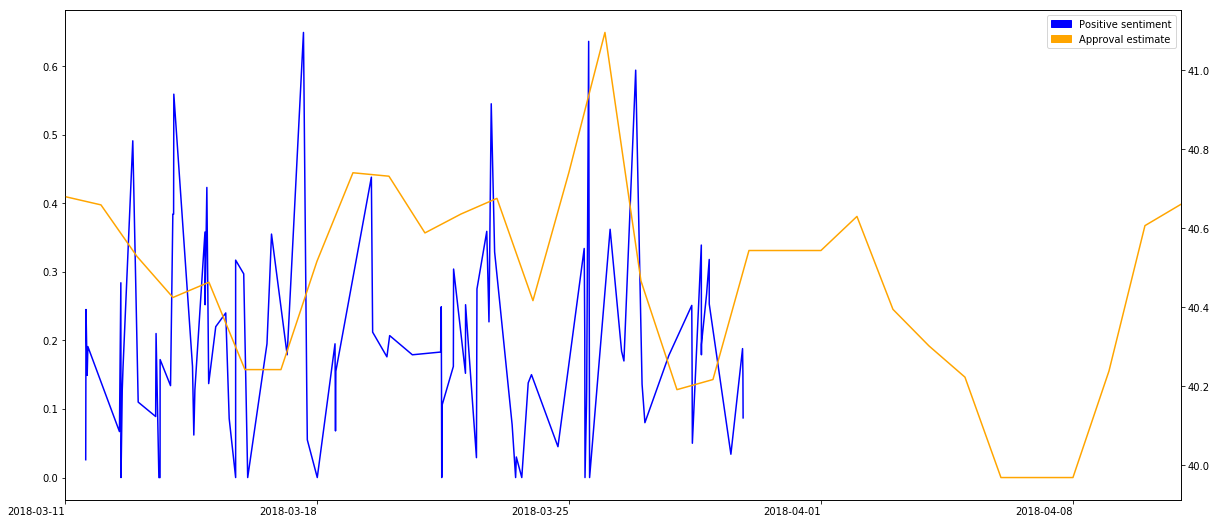

In [7]:
tweets_l00 = tweets[:100]

#positive sentiment of tweets
tweets_l00 = tweets_l00.rename(tweets_l00['created_at'])['pos']
plt.figure()
tweets_l00.plot(figsize=(20,10), color='blue')

#approval estimates
mindate = tweets_l00.index.min().to_pydatetime().date()
approval_estimates = approval_estimates.rename(approval_estimates['modeldate'])
approval_estimates['approve_estimate'].truncate(after=mindate).plot(secondary_y=True, color='orange')

#legend
blue_patch = mpatches.Patch(color='blue', label='Positive sentiment')
orange_patch = mpatches.Patch(color='orange', label='Approval estimate')
plt.legend(handles=[blue_patch,orange_patch])

# Install spaCy
[spaCy](https://spacy.io/usage/)

`>pip install -U spacy`

`>python -m spacy download en`

In [9]:
import spacy
from spacy import displacy

Run [spaCy's entity visualizer](https://spacy.io/usage/visualizers#section-ent) on Trump's last 200 tweets.

In [10]:
nlp = spacy.load('en')

tweets_200 = tweets[:200]
ents = {}
counts = {}

for index,row in tweets_200.iterrows():
    doc = nlp(row['text'])
    #accumulate named entities
    for ent in doc.ents:
        if ent.text in counts:
            counts[ent.text] += 1
        else:
            ents[ent.text] = ent.label_
            counts[ent.text] = 1
    #print `created_at` date
    print(row['created_at'])
    #visualize tweet
    displacy.render(doc, style='ent', jupyter=True)

2018-03-29 20:06:37


2018-03-29 19:58:35


2018-03-29 19:44:06


2018-03-29 11:57:38


2018-03-28 21:31:54


2018-03-28 21:31:08


2018-03-28 19:47:02


2018-03-28 16:19:02


2018-03-28 16:18:44


2018-03-28 16:14:34


2018-03-28 10:16:26


2018-03-28 10:05:18


2018-03-28 09:52:36


2018-03-27 18:35:06


2018-03-27 02:38:07


2018-03-27 00:44:52


2018-03-26 20:29:19


2018-03-26 12:38:55


2018-03-26 11:05:40


2018-03-26 03:26:43


2018-03-25 13:45:44


2018-03-25 13:08:27


2018-03-25 11:49:16


2018-03-25 11:40:41


2018-03-25 10:42:20


2018-03-25 10:33:25


2018-03-25 10:10:14


2018-03-24 16:40:11


2018-03-23 23:01:10


2018-03-23 20:50:30


2018-03-23 16:32:58


2018-03-23 12:55:15


2018-03-23 12:26:37


2018-03-23 10:07:18


2018-03-22 22:26:41


2018-03-22 20:11:30


2018-03-22 18:40:54


2018-03-22 17:12:52


2018-03-22 10:40:37


2018-03-22 10:19:57


2018-03-22 03:04:47


2018-03-22 03:00:36


2018-03-21 19:05:40


2018-03-21 18:56:14


2018-03-21 11:29:03


2018-03-21 11:11:17


2018-03-21 11:03:22


2018-03-21 10:52:27


2018-03-21 10:28:16


2018-03-20 15:36:23


2018-03-20 00:28:45


2018-03-19 22:38:15


2018-03-19 13:07:50


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-19 12:16:40


2018-03-18 12:35:42


2018-03-18 12:22:11


2018-03-18 12:02:31


2018-03-18 00:12:48


2018-03-17 17:34:21


2018-03-17 17:11:50


2018-03-17 15:00:54


2018-03-17 04:08:02


2018-03-16 17:42:07


2018-03-16 16:27:06


2018-03-16 14:40:53


2018-03-16 01:49:47


2018-03-15 23:10:56


2018-03-15 17:47:50


2018-03-15 17:47:34


2018-03-15 13:29:25


2018-03-15 11:11:39


2018-03-15 04:31:47


2018-03-14 23:49:09


2018-03-14 22:36:12


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-14 21:25:58


2018-03-14 21:20:42


2018-03-14 14:37:36


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-14 13:54:50


2018-03-14 13:12:09


2018-03-14 13:02:11


2018-03-14 00:34:44


2018-03-14 00:25:59


2018-03-13 23:55:27


2018-03-13 22:23:26


2018-03-13 15:27:18


2018-03-13 15:24:23


2018-03-13 14:37:15


2018-03-13 12:44:33


2018-03-13 12:28:03


2018-03-13 00:49:27


2018-03-12 21:13:12


2018-03-12 14:43:36


2018-03-12 14:12:11


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-12 13:22:38


2018-03-12 13:15:57


2018-03-12 12:20:03


2018-03-11 15:16:22


2018-03-11 14:49:29


2018-03-11 14:02:23


2018-03-11 13:50:47


2018-03-11 13:41:04


2018-03-11 01:37:31


2018-03-10 23:56:47


2018-03-10 21:29:37


2018-03-10 20:02:02


2018-03-10 18:38:17


2018-03-10 18:22:10


2018-03-10 17:23:16


2018-03-10 16:15:19


2018-03-10 15:52:04


2018-03-10 15:22:14


2018-03-10 13:38:51


2018-03-10 00:42:49


2018-03-09 22:48:52


2018-03-09 20:40:53


2018-03-09 20:35:10


2018-03-09 16:47:37


2018-03-09 01:08:14


2018-03-08 22:17:04


2018-03-08 22:16:36


2018-03-08 18:58:46


2018-03-08 18:20:06


2018-03-08 12:38:32


2018-03-07 15:38:49


2018-03-07 15:10:48


2018-03-07 11:40:29


2018-03-07 11:24:42


2018-03-07 10:44:26


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-07 00:49:30


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-06 14:11:54


2018-03-06 13:46:57


2018-03-06 13:25:15


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-06 13:07:08


2018-03-06 13:05:34


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-06 13:02:59


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-06 13:00:58


2018-03-06 12:55:35


2018-03-05 20:37:51


2018-03-05 13:22:29


2018-03-05 12:57:12


2018-03-05 11:53:48


2018-03-05 11:47:56


2018-03-05 00:10:12


2018-03-04 17:42:03


2018-03-03 17:53:50


2018-03-03 17:43:26


2018-03-03 17:33:53


2018-03-03 14:15:00


2018-03-02 20:31:22


2018-03-02 19:48:19


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-02 13:57:22


2018-03-02 13:01:58


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-02 11:18:28


2018-03-02 11:07:40


2018-03-02 10:50:34


2018-03-02 10:42:42


2018-03-02 03:04:51


2018-03-02 02:59:37


2018-03-02 02:58:35


2018-03-02 00:52:43


2018-03-02 00:51:28


2018-03-01 21:31:32


2018-03-01 20:40:52


2018-03-01 18:26:55


2018-03-01 18:06:30


2018-03-01 12:12:42


2018-03-01 11:53:58


2018-02-28 21:34:16


2018-02-28 19:01:34


2018-02-28 18:36:53


2018-02-28 17:10:22


2018-02-28 14:34:37


2018-02-28 14:08:21


2018-02-28 12:29:56


2018-02-28 12:02:58


2018-02-28 04:28:31


2018-02-28 04:20:43


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-02-27 22:58:19


2018-02-27 22:55:36


2018-02-27 18:18:22


2018-02-27 18:11:19


2018-02-27 12:49:41


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-02-27 12:45:58


2018-02-27 12:28:59


2018-02-27 11:59:30


2018-02-25 19:43:34


2018-02-25 03:56:04


2018-02-25 03:11:28


2018-02-25 03:10:28


2018-02-25 01:00:46


2018-02-25 00:56:35


2018-02-24 23:44:11


2018-02-24 23:20:06


2018-02-24 23:16:13


2018-02-24 22:26:15


2018-02-24 21:18:01


2018-02-24 21:07:43


2018-02-24 20:16:32


2018-02-24 18:54:14


2018-02-24 13:23:37


View the most frequently mentioned entities.

In [11]:
text = list(ents.keys())
labels = list(ents.values())
data = {'text':text,'label':labels}
df2 = pd.DataFrame(data)

for index,row in df2.iterrows():
    df2.at[index,'count'] = counts[row['text']]

#sort by count
df2 = df2.sort_values(by=['count'], ascending=False)
df2.head(30)

,label,text,count
15,GPE,U.S.,19.0
7,ORG,JOBS,12.0
54,PERSON,MAGA,12.0
42,NORP,Democrats,12.0
5,NORP,American,9.0
64,GPE,Russia,9.0
77,ORG,Congress,8.0
116,GPE,North Korea,8.0
128,PERSON,Trump,7.0
122,PERSON,Obama,7.0


Finally, define a function that runs sentiment analysis and named entity recognition on given text.

In [58]:
def process_tweet(text):
    vs = analyzer.polarity_scores(text)
    print('neg: ' + str(vs['neg']))
    print('neu: ' + str(vs['neu']))
    print('pos: ' + str(vs['pos']))
    print('compound: ' + str(vs['compound']))
    doc = nlp(text)
    displacy.render(doc, style='ent', jupyter=True)
    return doc.ents

# Uploading Trump's tweets to Amazon S3
We can get Trump's tweets using either the Twitter Streaming API or REST API. A comparison can be found [here](https://stackoverflow.com/questions/5960128/streaming-api-vs-rest-api).

[tweepy](https://github.com/tweepy/tweepy) is a Python wrapper of the Twitter API.

`>pip install tweepy`

[Boto3](https://github.com/boto/boto3) is the AWS SDK for Python.

`>pip install boto3`

Create a [Twitter App](https://apps.twitter.com/) and navigate to "Keys and Access Tokens."

Store the four application tokens in `application_tokens.py`, along with your AWS access key ID and secret access key.
```
consumer_key = 'your_consumer_key'
consumer_secret = 'your_consumer_secret'
access_token = 'your_access_token_key'
access_token_secret = 'your_access_token_secret'
aws_access_key_id = 'your_aws_access_key_id'
aws_secret_access_key = 'your_aws_secret_access_key'
```

In [48]:
import tweepy
import boto3
from application_tokens import *

Set up tweepy.

In [49]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

api = tweepy.API(auth)

Set up boto3.

[Creating the connection and creating a bucket](http://boto3.readthedocs.io/en/latest/guide/migrations3.html#creating-the-connection)

In [50]:
#name of your bucket
bucket_name = 'trump-snapshot'

#create the connection
s3 = boto3.resource('s3',
                      aws_access_key_id=aws_access_key_id,
                      aws_secret_access_key=aws_secret_access_key)

#create a bucket
s3.create_bucket(Bucket=bucket_name)

s3.Bucket(name='trump-snapshot')

Define a function to update the S3 database with Trump's most recent tweets.

[Storing data](http://boto3.readthedocs.io/en/latest/guide/migrations3.html#storing-data)

In [40]:
def update_database(filename):
    s3.Object(bucket_name, filename).put(Body=open(filename, 'rb'))

Define a function to get a user's most recent tweets.

In [28]:
def get_tweets(screen_name, count):
    new_tweets = api.user_timeline(screen_name=screen_name,count=count, tweet_mode='extended')
    new_tweets = [{"created_at":i.created_at.strftime("%Y-%m-%d %H:%M:%S"),"id": i.id,'retweet_count':i.retweet_count,'favorite_count':i.favorite_count,'text':i.full_text} for i in new_tweets]
    return new_tweets

Check Trump's last 200 tweets and upload them to an S3 database. Keep track of the named entities mentioned.

In [86]:
ents = {}
counts = {}

for i in get_tweets('realDonaldTrump', 200):
    tweet_ents = process_tweet(i['text'])
    #accumulate named entities
    for ent in tweet_ents:
        if ent.text in counts:
            counts[ent.text] += 1
        else:
            ents[ent.text] = ent.label_
            counts[ent.text] = 1

with open('new_tweets.json','wb') as f:
    f.write(json.dumps(get_tweets('realDonaldTrump', 200)).encode('utf-8'))

#update_database('new_tweets.json')

neg: 0.0
neu: 0.913
pos: 0.087
compound: 0.3182


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.035
neu: 0.787
pos: 0.178
compound: 0.7088


neg: 0.203
neu: 0.761
pos: 0.036
compound: -0.8643


neg: 0.18
neu: 0.727
pos: 0.093
compound: -0.6712


neg: 0.258
neu: 0.588
pos: 0.153
compound: -0.7835


neg: 0.202
neu: 0.798
pos: 0.0
compound: -0.863


neg: 0.14
neu: 0.719
pos: 0.141
compound: 0.0038


neg: 0.191
neu: 0.737
pos: 0.072
compound: -0.7579


neg: 0.0
neu: 0.521
pos: 0.479
compound: 0.9606


neg: 0.0
neu: 0.563
pos: 0.437
compound: 0.9577


neg: 0.04
neu: 0.697
pos: 0.263
compound: 0.934


neg: 0.628
neu: 0.372
pos: 0.0
compound: -0.5229


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.505
neu: 0.22
pos: 0.275
compound: -0.4753


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.672
pos: 0.328
compound: 0.6588


neg: 0.0
neu: 0.817
pos: 0.183
compound: 0.6588


neg: 0.461
neu: 0.449
pos: 0.09
compound: -0.872


neg: 0.092
neu: 0.668
pos: 0.24
compound: 0.8465


neg: 0.0
neu: 0.412
pos: 0.588
compound: 0.9899


neg: 0.158
neu: 0.842
pos: 0.0
compound: -0.6892


neg: 0.434
neu: 0.469
pos: 0.097
compound: -0.8528


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.199
neu: 0.735
pos: 0.066
compound: -0.836


neg: 0.083
neu: 0.714
pos: 0.202
compound: 0.7901


neg: 0.0
neu: 0.783
pos: 0.217
compound: 0.8775


neg: 0.063
neu: 0.776
pos: 0.162
compound: 0.6077


neg: 0.11
neu: 0.642
pos: 0.247
compound: 0.8087


neg: 0.092
neu: 0.615
pos: 0.293
compound: 0.7371


neg: 0.069
neu: 0.677
pos: 0.254
compound: 0.8117


neg: 0.276
neu: 0.663
pos: 0.061
compound: -0.9006


neg: 0.108
neu: 0.551
pos: 0.341
compound: 0.7836


neg: 0.171
neu: 0.774
pos: 0.056
compound: -0.6996


neg: 0.26
neu: 0.593
pos: 0.147
compound: -0.6114


neg: 0.0
neu: 0.564
pos: 0.436
compound: 0.9381


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.153
neu: 0.803
pos: 0.044
compound: -0.7508


neg: 0.119
neu: 0.71
pos: 0.171
compound: 0.4019


neg: 0.222
neu: 0.592
pos: 0.186
compound: -0.0536


neg: 0.0
neu: 0.906
pos: 0.094
compound: 0.3578


neg: 0.0
neu: 0.496
pos: 0.504
compound: 0.9538


neg: 0.13
neu: 0.678
pos: 0.192
compound: 0.4906


neg: 0.292
neu: 0.708
pos: 0.0
compound: -0.9302


neg: 0.191
neu: 0.67
pos: 0.139
compound: -0.481


neg: 0.0
neu: 0.807
pos: 0.193
compound: 0.4767


neg: 0.083
neu: 0.702
pos: 0.215
compound: 0.7351


neg: 0.118
neu: 0.731
pos: 0.151
compound: 0.34


neg: 0.272
neu: 0.728
pos: 0.0
compound: -0.4574


neg: 0.175
neu: 0.666
pos: 0.16
compound: 0.1739


neg: 0.058
neu: 0.778
pos: 0.164
compound: 0.7075


neg: 0.0
neu: 0.937
pos: 0.063
compound: 0.3612


neg: 0.0
neu: 0.623
pos: 0.377
compound: 0.561


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.722
pos: 0.278
compound: 0.8858


neg: 0.028
neu: 0.842
pos: 0.13
compound: 0.6239


neg: 0.0
neu: 0.791
pos: 0.209
compound: 0.7003


neg: 0.125
neu: 0.727
pos: 0.149
compound: 0.3378


neg: 0.034
neu: 0.83
pos: 0.135
compound: 0.68


neg: 0.254
neu: 0.695
pos: 0.051
compound: -0.8994


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.925
pos: 0.075
compound: 0.4767


neg: 0.049
neu: 0.857
pos: 0.094
compound: 0.4753


neg: 0.164
neu: 0.735
pos: 0.101
compound: -0.5318


neg: 0.194
neu: 0.766
pos: 0.039
compound: -0.7719


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.741
pos: 0.259
compound: 0.5411


neg: 0.256
neu: 0.744
pos: 0.0
compound: -0.8235


neg: 0.252
neu: 0.678
pos: 0.07
compound: -0.8786


neg: 0.272
neu: 0.566
pos: 0.162
compound: -0.7184


neg: 0.11
neu: 0.767
pos: 0.123
compound: 0.1742


neg: 0.23
neu: 0.643
pos: 0.127
compound: -0.7644


neg: 0.175
neu: 0.733
pos: 0.092
compound: -0.698


neg: 0.114
neu: 0.828
pos: 0.058
compound: -0.242


neg: 0.0
neu: 0.826
pos: 0.174
compound: 0.3802


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.14
neu: 0.771
pos: 0.088
compound: -0.4493


neg: 0.204
neu: 0.748
pos: 0.048
compound: -0.7974


neg: 0.0
neu: 0.2
pos: 0.8
compound: 0.6114


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.393
neu: 0.485
pos: 0.122
compound: -0.9567


neg: 0.146
neu: 0.772
pos: 0.082
compound: -0.5168


neg: 0.135
neu: 0.833
pos: 0.031
compound: -0.6808


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.051
neu: 0.862
pos: 0.087
compound: 0.3647


neg: 0.297
neu: 0.552
pos: 0.151
compound: -0.4559


neg: 0.04
neu: 0.772
pos: 0.188
compound: 0.8516


neg: 0.117
neu: 0.85
pos: 0.034
compound: -0.4962


neg: 0.0
neu: 0.747
pos: 0.253
compound: 0.8697


neg: 0.0
neu: 0.682
pos: 0.318
compound: 0.8347


neg: 0.0
neu: 0.732
pos: 0.268
compound: 0.6588


neg: 0.213
neu: 0.594
pos: 0.194
compound: -0.1531


neg: 0.115
neu: 0.705
pos: 0.179
compound: 0.25


neg: 0.0
neu: 0.661
pos: 0.339
compound: 0.8955


neg: 0.101
neu: 0.849
pos: 0.05
compound: -0.3609


neg: 0.0
neu: 0.835
pos: 0.165
compound: 0.8268


neg: 0.054
neu: 0.696
pos: 0.251
compound: 0.8945


neg: 0.222
neu: 0.601
pos: 0.178
compound: -0.3475


neg: 0.0
neu: 0.92
pos: 0.08
compound: 0.25


neg: 0.08
neu: 0.784
pos: 0.136
compound: 0.3939


neg: 0.0
neu: 0.406
pos: 0.594
compound: 0.6588


neg: 0.131
neu: 0.698
pos: 0.17
compound: 0.2532


neg: 0.069
neu: 0.747
pos: 0.184
compound: 0.6107


neg: 0.0
neu: 0.638
pos: 0.362
compound: 0.9741


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.364
pos: 0.636
compound: 0.922


neg: 0.136
neu: 0.735
pos: 0.129
compound: 0.2851


neg: 0.126
neu: 0.769
pos: 0.105
compound: -0.296


neg: 0.073
neu: 0.927
pos: 0.0
compound: -0.5093


neg: 0.063
neu: 0.732
pos: 0.205
compound: 0.7901


neg: 0.278
neu: 0.388
pos: 0.334
compound: 0.5378


neg: 0.405
neu: 0.55
pos: 0.045
compound: -0.9665


neg: 0.0
neu: 0.85
pos: 0.15
compound: 0.6588


neg: 0.282
neu: 0.58
pos: 0.138
compound: -0.8647


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.117
neu: 0.853
pos: 0.03
compound: -0.659


neg: 0.382
neu: 0.618
pos: 0.0
compound: -0.8513


neg: 0.055
neu: 0.868
pos: 0.077
compound: 0.2263


neg: 0.0
neu: 0.671
pos: 0.329
compound: 0.9617


neg: 0.0
neu: 0.455
pos: 0.545
compound: 0.7177


neg: 0.168
neu: 0.605
pos: 0.227
compound: 0.4019


neg: 0.0
neu: 0.641
pos: 0.359
compound: 0.4215


neg: 0.0
neu: 0.725
pos: 0.275
compound: 0.939


neg: 0.303
neu: 0.669
pos: 0.029
compound: -0.9299


neg: 0.144
neu: 0.604
pos: 0.252
compound: 0.5818


neg: 0.079
neu: 0.769
pos: 0.152
compound: 0.5984


neg: 0.032
neu: 0.663
pos: 0.304
compound: 0.9485


neg: 0.135
neu: 0.702
pos: 0.162
compound: 0.3699


neg: 0.069
neu: 0.825
pos: 0.106
compound: 0.2263


neg: 0.193
neu: 0.807
pos: 0.0
compound: -0.7177


neg: 0.094
neu: 0.656
pos: 0.249
compound: 0.7096


neg: 0.369
neu: 0.447
pos: 0.183
compound: -0.6319


neg: 0.0
neu: 0.821
pos: 0.179
compound: 0.8327


neg: 0.178
neu: 0.615
pos: 0.207
compound: 0.3722


neg: 0.198
neu: 0.626
pos: 0.176
compound: 0.09


neg: 0.434
neu: 0.354
pos: 0.212
compound: -0.481


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.562
pos: 0.438
compound: 0.6892


neg: 0.078
neu: 0.768
pos: 0.155
compound: 0.444


neg: 0.167
neu: 0.765
pos: 0.068
compound: -0.7351


neg: 0.059
neu: 0.747
pos: 0.195
compound: 0.7184


neg: 0.292
neu: 0.708
pos: 0.0
compound: -0.9495


neg: 0.177
neu: 0.769
pos: 0.055
compound: -0.7982


neg: 0.112
neu: 0.758
pos: 0.13
compound: 0.2263


neg: 0.0
neu: 0.351
pos: 0.649
compound: 0.5719


neg: 0.139
neu: 0.683
pos: 0.179
compound: 0.536


neg: 0.0
neu: 0.645
pos: 0.355
compound: 0.5106


neg: 0.0
neu: 0.713
pos: 0.287
compound: 0.9168


neg: 0.109
neu: 0.696
pos: 0.195
compound: 0.608


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.23
neu: 0.473
pos: 0.297
compound: 0.5263


neg: 0.0
neu: 0.683
pos: 0.317
compound: 0.7574


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.039
neu: 0.875
pos: 0.086
compound: 0.3157


neg: 0.039
neu: 0.721
pos: 0.24
compound: 0.8977


neg: 0.0
neu: 0.78
pos: 0.22
compound: 0.5423


neg: 0.106
neu: 0.757
pos: 0.137
compound: 0.3525


neg: 0.0
neu: 0.577
pos: 0.423
compound: 0.729


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.18
neu: 0.568
pos: 0.252
compound: 0.3734


neg: 0.0
neu: 0.642
pos: 0.358
compound: 0.4199


neg: 0.192
neu: 0.68
pos: 0.128
compound: -0.281


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.938
pos: 0.062
compound: 0.4199


neg: 0.098
neu: 0.759
pos: 0.143
compound: 0.2481


neg: 0.136
neu: 0.702
pos: 0.162
compound: -0.1043


neg: 0.0
neu: 0.441
pos: 0.559
compound: 0.9684


neg: 0.0
neu: 0.616
pos: 0.384
compound: 0.9742


neg: 0.048
neu: 0.818
pos: 0.134
compound: 0.5562


neg: 0.306
neu: 0.522
pos: 0.172
compound: -0.8564


neg: 0.215
neu: 0.785
pos: 0.0
compound: -0.8176


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.79
pos: 0.21
compound: 0.9033


neg: 0.113
neu: 0.798
pos: 0.089
compound: -0.2003


neg: 0.084
neu: 0.805
pos: 0.11
compound: 0.2263


neg: 0.0
neu: 0.509
pos: 0.491
compound: 0.9381


neg: 0.121
neu: 0.718
pos: 0.161
compound: 0.2716


neg: 0.288
neu: 0.584
pos: 0.128
compound: -0.8016


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.083
neu: 0.917
pos: 0.0
compound: -0.438


neg: 0.0
neu: 0.716
pos: 0.284
compound: 0.9286


neg: 0.0
neu: 0.933
pos: 0.067
compound: 0.3182


neg: 0.129
neu: 0.679
pos: 0.191
compound: 0.536


neg: 0.0
neu: 0.851
pos: 0.149
compound: 0.7574


neg: 0.109
neu: 0.646
pos: 0.245
compound: 0.7506


neg: 0.152
neu: 0.822
pos: 0.026
compound: -0.743


neg: 0.136
neu: 0.634
pos: 0.23
compound: 0.7526


neg: 0.0
neu: 0.752
pos: 0.248
compound: 0.8367


neg: 0.0
neu: 0.664
pos: 0.336
compound: 0.7644


neg: 0.253
neu: 0.604
pos: 0.142
compound: -0.747


neg: 0.034
neu: 0.895
pos: 0.071
compound: 0.4321


neg: 0.0
neu: 0.736
pos: 0.264
compound: 0.8221


neg: 0.079
neu: 0.646
pos: 0.276
compound: 0.9259


neg: 0.052
neu: 0.774
pos: 0.174
compound: 0.7419


neg: 0.094
neu: 0.755
pos: 0.151
compound: 0.4753


neg: 0.0
neu: 0.676
pos: 0.324
compound: 0.9184


neg: 0.362
neu: 0.552
pos: 0.086
compound: -0.8399


neg: 0.0
neu: 0.823
pos: 0.177
compound: 0.6801


neg: 0.041
neu: 0.683
pos: 0.276
compound: 0.9144


neg: 0.0
neu: 0.765
pos: 0.235
compound: 0.7896


neg: 0.0
neu: 0.889
pos: 0.111
compound: 0.4574


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.054
neu: 0.73
pos: 0.216
compound: 0.8388


neg: 0.0
neu: 0.843
pos: 0.157
compound: 0.4215


neg: 0.0
neu: 0.843
pos: 0.157
compound: 0.4215


neg: 0.0
neu: 0.672
pos: 0.328
compound: 0.6588


neg: 0.0
neu: 0.67
pos: 0.33
compound: 0.7845


neg: 0.0
neu: 0.743
pos: 0.257
compound: 0.9313


neg: 0.065
neu: 0.707
pos: 0.228
compound: 0.6281


Plot the most frequently-mentioned entities.

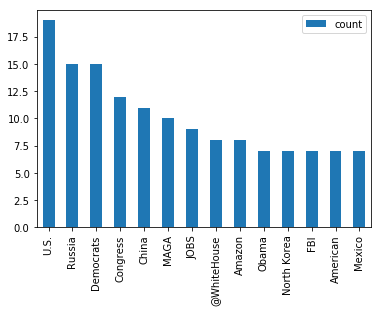

In [88]:
text = list(ents.keys())
labels = list(ents.values())
data = {'text':text,'label':labels}
df2 = pd.DataFrame(data)

for index,row in df2.iterrows():
    df2.at[index,'count'] = counts[row['text']]

#sort by count greater than 7
df2 = df2[df2['count'] >= 7]
df2 = df2.sort_values(by=['count'], ascending=False)
ax = df2.plot.bar()
ax.set_xticklabels(df2['text'], rotation=90)

Save the figure as an image and tweet it out.

In [90]:
filename = 'fig.png'
ax.get_figure().savefig(filename, bbox_inches='tight')
#api.update_with_media(filename, status='test')

# Appendix

Old walkthroughs.

## Using the Streaming API
We can get a real-time stream that "[follows](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters#follow)" @realDonaldTrump. This stream includes but is not limited to tweets authored by him, so we need to filter the tweets by author.

[Streaming with Tweepy](http://docs.tweepy.org/en/v3.6.0/streaming_how_to.html)

[Standard stream parameters](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters)

In [56]:
screen_name = 'realDonaldTrump'
id_str = api.get_user(screen_name).id_str

class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        #if status authored by `realDonaldTrump`
        #if (status.author.screen_name == screen_name):
        #    process_tweet(status.text)
        process_tweet(status.text)
            
    def on_error(self, status_code):
        #if rate-limited
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False
        #returning non-False reconnects the stream, with backoff.

We can quickly preview the output of `process_tweet()` by running it on the full stream.

In [110]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
myStream.filter(follow=[id_str])

neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.171
neu: 0.702
pos: 0.127
compound: -0.25


neg: 0.0
neu: 0.5
pos: 0.5
compound: 0.7901


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.538
neu: 0.462
pos: 0.0
compound: -0.5423


neg: 0.0
neu: 0.846
pos: 0.154
compound: 0.5362


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.284
neu: 0.716
pos: 0.0
compound: -0.6093


neg: 0.06
neu: 0.94
pos: 0.0
compound: -0.1027


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.816
pos: 0.184
compound: 0.5423


neg: 0.0
neu: 0.814
pos: 0.186
compound: 0.6249


neg: 0.0
neu: 0.728
pos: 0.272
compound: 0.7154


neg: 0.0
neu: 0.814
pos: 0.186
compound: 0.6249


neg: 0.326
neu: 0.674
pos: 0.0
compound: -0.4404


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.824
pos: 0.176
compound: 0.4574


neg: 0.114
neu: 0.774
pos: 0.112
compound: -0.0085


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.222
neu: 0.592
pos: 0.186
compound: -0.0536


neg: 0.0
neu: 0.922
pos: 0.078
compound: 0.1779


KeyboardInterrupt: 

## Using the REST API

In [101]:
#retrieve realDonaldTrump's most recent tweet (non-truncated)
screen_name = 'realDonaldTrump'
user_timeline = api.user_timeline(screen_name=screen_name, count=1, tweet_mode='extended')
#store id of most recent tweet
since_id = user_timeline[0].id
process_tweet(user_timeline[0].full_text)

neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


We can wrap the code below to query the API periodically.

In [103]:
#retrieve most recent statuses since specified id
user_timeline = api.user_timeline(screen_name=screen_name, count=1, tweet_mode='extended', since_id=since_id)

if(len(user_timeline) > 0):
    since_id = user_timeline[0].id
    for tweet in user_timeline:
        process_tweet(tweet.text)
else:
    print("No new tweets since id: " + str(since_id))

No new tweets since id: 982292963492413442
